In [39]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit

RANDOM_STATE = 42
pd.set_option("display.max_columns", None)

In [45]:
# read data again
df = pd.read_csv("data/raw/Life Expectancy Data.csv")
df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [53]:
# clean column name
df = df.copy()
df.columns = (df.columns
              .str.strip()
              .str.replace(' ','_', regex=False)
              .str.replace('-','_', regex=False)
              .str.replace(r'_+', '_', regex=True)  # replace multiple underscores with single
              .str.lower())

target = "life_expectancy"
group_col = "country"
time_col  = "year"

print(list(df.columns))
df[[target, group_col, time_col]].head()

['country', 'year', 'status', 'life_expectancy', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b', 'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure', 'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_1_19_years', 'thinness_5_9_years', 'income_composition_of_resources', 'schooling']


,life_expectancy,country,year
0,65.0,Afghanistan,2015
1,59.9,Afghanistan,2014
2,59.9,Afghanistan,2013
3,59.5,Afghanistan,2012
4,59.2,Afghanistan,2011


In [54]:
# missing overview
print("Shape:", df.shape)
missing_ratio = df.isna().mean().sort_values(ascending=False)
display(missing_ratio.head(12))

Shape: (2938, 22)


population                         0.221920
hepatitis_b                        0.188223
gdp                                0.152485
total_expenditure                  0.076923
alcohol                            0.066031
income_composition_of_resources    0.056841
schooling                          0.055480
thinness_5_9_years                 0.011572
thinness_1_19_years                0.011572
bmi                                0.011572
polio                              0.006467
diphtheria                         0.006467
dtype: float64

In [55]:
# remove rows with missing target values
df_clean = df.dropna(subset=[target]).copy()
print(f"Dropped {len(df) - len(df_clean)} rows with missing target")
print(f"Remaining: {len(df_clean)} rows")

# split target and X
y = df_clean[target]
X = df_clean.drop(columns=[target])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

# remove time and group from features
if group_col in num_cols:
    num_cols.remove(group_col)
if time_col in num_cols:
    num_cols.remove(time_col)
if group_col in cat_cols:
    cat_cols.remove(group_col)
if time_col in cat_cols:
    cat_cols.remove(time_col)

print("Numeric cols:", len(num_cols), num_cols)
print("Categorical cols:", cat_cols)

Dropped 10 rows with missing target
Remaining: 2928 rows
Numeric cols: 18 ['adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b', 'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure', 'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_1_19_years', 'thinness_5_9_years', 'income_composition_of_resources', 'schooling']
Categorical cols: ['status']


In [59]:
# log transform
log_cols = [    # determine in eda, right skewed
    "gdp",
    "population",
    "percentage_expenditure",
    "measles",
    "hiv/aids",
    "infant_deaths",
    "under_five_deaths"
]

def log1p_selected(X_df):
    X_df = X_df.copy()
    for c in log_cols:
        if c in X_df.columns:
            X_df[c] = np.log1p(X_df[c].astype(float))
    return X_df

log_transformer = FunctionTransformer(log1p_selected, feature_names_out="one-to-one")

In [61]:
# missing value
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # median for skewed features
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    # no imputer needed - status has no missing values
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("cat", categorical_pipe, cat_cols)
    ],
    remainder="drop"
)

In [62]:
# full pipeline
full_pipeline = Pipeline(steps=[
    ("log", log_transformer),
    ("prep", preprocessor)
])

In [69]:
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
import seaborn as sns

print("Modeling libraries imported")

Modeling libraries imported


In [64]:
# split out the test set
groups = X[group_col]

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

groups_train = groups.iloc[train_idx]

print(f"Train set shape: {X_train.shape}")
print(f"Test set shape:  {X_test.shape}")

# check for leakage
overlapping = set(groups.iloc[train_idx]) & set(groups.iloc[test_idx])
print(f"Overlapping countries: {overlapping}")

Train set shape: (2336, 21)
Test set shape:  (592, 21)
Overlapping countries: set()


Starting Cross-Validation
 >> Linear Regression: RMSE=3.823 (+/- 0.506)
 >> Ridge: RMSE=3.824 (+/- 0.505)
 >> Lasso: RMSE=4.135 (+/- 0.442)
 >> Random Forest: RMSE=2.960 (+/- 0.247)
 >> Random Forest: RMSE=2.960 (+/- 0.247)
 >> XGBoost: RMSE=3.011 (+/- 0.231)
 >> XGBoost: RMSE=3.011 (+/- 0.231)


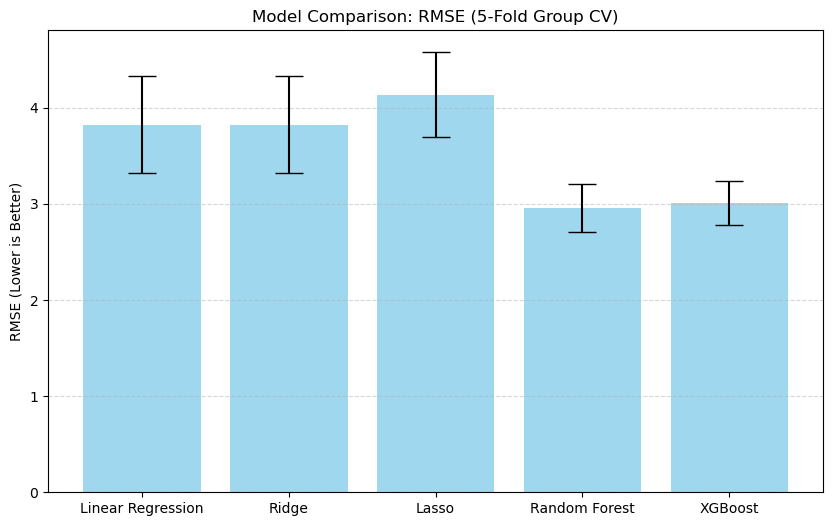


--- Model Rankings ---


,Model,RMSE_Mean,RMSE_Std,R2_Mean,R2_Std
3,Random Forest,2.959811,0.247208,0.898359,0.014326
4,XGBoost,3.011136,0.230811,0.894430,0.017614
0,Linear Regression,3.822997,0.505932,0.830009,0.036459
1,Ridge,3.824370,0.505081,0.829871,0.036457
2,Lasso,4.135202,0.442360,0.800125,0.040328


In [65]:
# model training and cross validation
gkf = GroupKFold(n_splits=5)

# models to test
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=RANDOM_STATE),
    'Lasso': Lasso(random_state=RANDOM_STATE),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=RANDOM_STATE, n_jobs=-1)
}

results_list = []

print("Starting Cross-Validation")

for name, model in models.items():
    model_pipe = Pipeline(steps=[
        ('preprocessing', full_pipeline), 
        ('model', model)
    ])
    
    cv_scores = cross_validate(
        model_pipe, 
        X_train, 
        y_train, 
        groups=groups_train, 
        cv=gkf, 
        scoring=['neg_root_mean_squared_error', 'r2']
    )
    
    rmse_scores = -cv_scores['test_neg_root_mean_squared_error']
    r2_scores = cv_scores['test_r2']
    
    results_list.append({
        'Model': name,
        'RMSE_Mean': rmse_scores.mean(),
        'RMSE_Std': rmse_scores.std(),
        'R2_Mean': r2_scores.mean(),
        'R2_Std': r2_scores.std()
    })
    
    print(f" >> {name}: RMSE={rmse_scores.mean():.3f} (+/- {rmse_scores.std():.3f})")

results_df = pd.DataFrame(results_list)

# visualization
plt.figure(figsize=(10, 6))

plt.bar(
    results_df['Model'], 
    results_df['RMSE_Mean'], 
    yerr=results_df['RMSE_Std'], 
    capsize=10, 
    color='skyblue', 
    alpha=0.8
)
plt.title('Model Comparison: RMSE (5-Fold Group CV)')
plt.ylabel('RMSE (Lower is Better)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

print("\n--- Model Rankings ---")
display(results_df.sort_values('RMSE_Mean'))

In [ ]:
# random forest hyperparameter tune
print("Starting Grid Search CV for Random Forest")

param_grid_rf = {
    'model__n_estimators': [150, 500],
    'model__max_depth': [None, 20],
    'model__min_samples_leaf': [1, 4],
    'model__max_features': [None, 'sqrt']
}

rf_tune_pipe = Pipeline(steps=[
    ('preprocessing', full_pipeline),
    ('model', RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

rf_grid = GridSearchCV(
    rf_tune_pipe,
    param_grid_rf,
    cv=gkf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    return_train_score=False,
    verbose=1
)

rf_grid.fit(X_train, y_train, groups=groups_train)

print(f"\nBest RF Params: {rf_grid.best_params_}")
print(f"Best RF CV RMSE: {-rf_grid.best_score_:.4f}")

Starting Grid Search CV for Random Forest
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Best RF Params: {'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 500}
Best RF CV RMSE: 2.9540

Best RF Params: {'model__max_depth': None, 'model__max_features': None, 'model__min_samples_leaf': 1, 'model__n_estimators': 500}
Best RF CV RMSE: 2.9540


In [68]:
# xgboost hyperparameter tune
print("Starting Grid Search for XGBoost")

param_grid_xgb = {
    'model__n_estimators': [300, 500, 1000],
    'model__learning_rate': [0.01, 0.05],
    'model__max_depth': [3, 5, 7],
    'model__min_child_weight': [3, 5],
    'model__subsample': [0.5, 0.7],
    'model__colsample_bytree': [0.5, 0.7]
}

xgb_tune_pipe = Pipeline(steps=[
    ('preprocessing', full_pipeline),
    ('model', XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1))
])

xgb_grid = GridSearchCV(
    xgb_tune_pipe,
    param_grid_xgb,
    cv=gkf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train, groups=groups_train)

print(f"\nBest XGB Params: {xgb_grid.best_params_}")
print(f"Best XGB CV RMSE: {-xgb_grid.best_score_:.4f}")

Starting Grid Search for XGBoost
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best XGB Params: {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 3, 'model__n_estimators': 1000, 'model__subsample': 0.7}
Best XGB CV RMSE: 2.7843

Best XGB Params: {'model__colsample_bytree': 0.5, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__min_child_weight': 3, 'model__n_estimators': 1000, 'model__subsample': 0.7}
Best XGB CV RMSE: 2.7843


In [ ]:
# final test set evaluation
print("Evaluation on test set\n")

# baseline (mean prediction)
print("1. Baseline Model (Mean Predictor)")
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train[[]], y_train)
y_pred_dummy = dummy.predict(X_test[[]])
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
r2_baseline = r2_score(y_test, y_pred_dummy)
print(f"   Baseline RMSE: {rmse_baseline:.4f}")
print(f"   Baseline R²:   {r2_baseline:.4f}")

# linear regression
print("\n2. Linear Regression")
lr_pipe = Pipeline(steps=[
    ('preprocessing', full_pipeline), 
    ('model', LinearRegression())
])
lr_pipe.fit(X_train, y_train)
y_pred_lr = lr_pipe.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print(f"   LR Test RMSE:  {rmse_lr:.4f}")
print(f"   LR Test R²:    {r2_lr:.4f}")

# ridge regression
print("\n3. Ridge Regression")
ridge_pipe = Pipeline(steps=[
    ('preprocessing', full_pipeline), 
    ('model', Ridge(random_state=RANDOM_STATE))
])
ridge_pipe.fit(X_train, y_train)
y_pred_ridge = ridge_pipe.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f"   Ridge Test RMSE: {rmse_ridge:.4f}")
print(f"   Ridge Test R²:   {r2_ridge:.4f}")

# lasso regression
print("\n4. Lasso Regression")
lasso_pipe = Pipeline(steps=[
    ('preprocessing', full_pipeline), 
    ('model', Lasso(random_state=RANDOM_STATE))
])
lasso_pipe.fit(X_train, y_train)
y_pred_lasso = lasso_pipe.predict(X_test)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f"   Lasso Test RMSE: {rmse_lasso:.4f}")
print(f"   Lasso Test R²:   {r2_lasso:.4f}")

# random forest (tuned)
print("\n5. Random Forest (Grid Search Best)")
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
print(f"   RF Test RMSE:  {rmse_rf:.4f}")
print(f"   RF Test R²:    {r2_rf:.4f}")
print(f"   RF CV RMSE:    {-rf_grid.best_score_:.4f}")

# xgboost (tuned)
print("\n6. XGBoost (Grid Search Best)")
xgb_best = xgb_grid.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"   XGB Test RMSE: {rmse_xgb:.4f}")
print(f"   XGB Test R²:   {r2_xgb:.4f}")
print(f"   XGB CV RMSE:   {-xgb_grid.best_score_:.4f}")

# summary table
print("\nSummary Table")
test_results = pd.DataFrame({
    'Model': ['Baseline (Mean)', 'Linear Regression', 'Ridge', 'Lasso', 'Random Forest', 'XGBoost'],
    'Test_RMSE': [rmse_baseline, rmse_lr, rmse_ridge, rmse_lasso, rmse_rf, rmse_xgb],
    'Test_R2': [r2_baseline, r2_lr, r2_ridge, r2_lasso, r2_rf, r2_xgb],
    'CV_RMSE': [np.nan, np.nan, np.nan, np.nan, -rf_grid.best_score_, -xgb_grid.best_score_]
})
display(test_results.sort_values('Test_RMSE'))

# improvement over baseline
print(f"\nLR improvement over baseline: {(rmse_baseline - rmse_lr)/rmse_baseline * 100:.1f}%")
print(f"Ridge improvement over baseline: {(rmse_baseline - rmse_ridge)/rmse_baseline * 100:.1f}%")
print(f"Lasso improvement over baseline: {(rmse_baseline - rmse_lasso)/rmse_baseline * 100:.1f}%")
print(f"RF improvement over baseline: {(rmse_baseline - rmse_rf)/rmse_baseline * 100:.1f}%")
print(f"XGB improvement over baseline: {(rmse_baseline - rmse_xgb)/rmse_baseline * 100:.1f}%")

Evaluation on test set

1. Baseline Model (Mean Predictor)
   Baseline RMSE: 9.9487
   Baseline R²:   -0.0593

2. Linear Regression
   LR Test RMSE:  3.5188
   LR Test R²:    0.8675

3. Ridge Regression
   Ridge Test RMSE: 3.4977
   Ridge Test R²:   0.8691

4. Lasso Regression
   Lasso Test RMSE: 3.8517
   Lasso Test R²:   0.8412

5. Random Forest (Grid Search Best)
   RF Test RMSE:  2.8337
   RF Test R²:    0.9141
   RF CV RMSE:    2.9540

6. XGBoost (Grid Search Best)
   XGB Test RMSE: 2.5774
   XGB Test R²:   0.9289
   XGB CV RMSE:   2.7843

SUMMARY TABLE


,Model,Test_RMSE,Test_R2,CV_RMSE
5,XGBoost,2.577372,0.928902,2.784311
4,Random Forest,2.833684,0.914058,2.953982
2,Ridge,3.497743,0.869058,NaN
1,Linear Regression,3.518751,0.867480,NaN
3,Lasso,3.851749,0.841211,NaN
0,Baseline (Mean),9.948670,-0.059335,NaN



LR improvement over baseline: 64.6%
Ridge improvement over baseline: 64.8%
Lasso improvement over baseline: 61.3%
RF improvement over baseline: 71.5%
XGB improvement over baseline: 74.1%


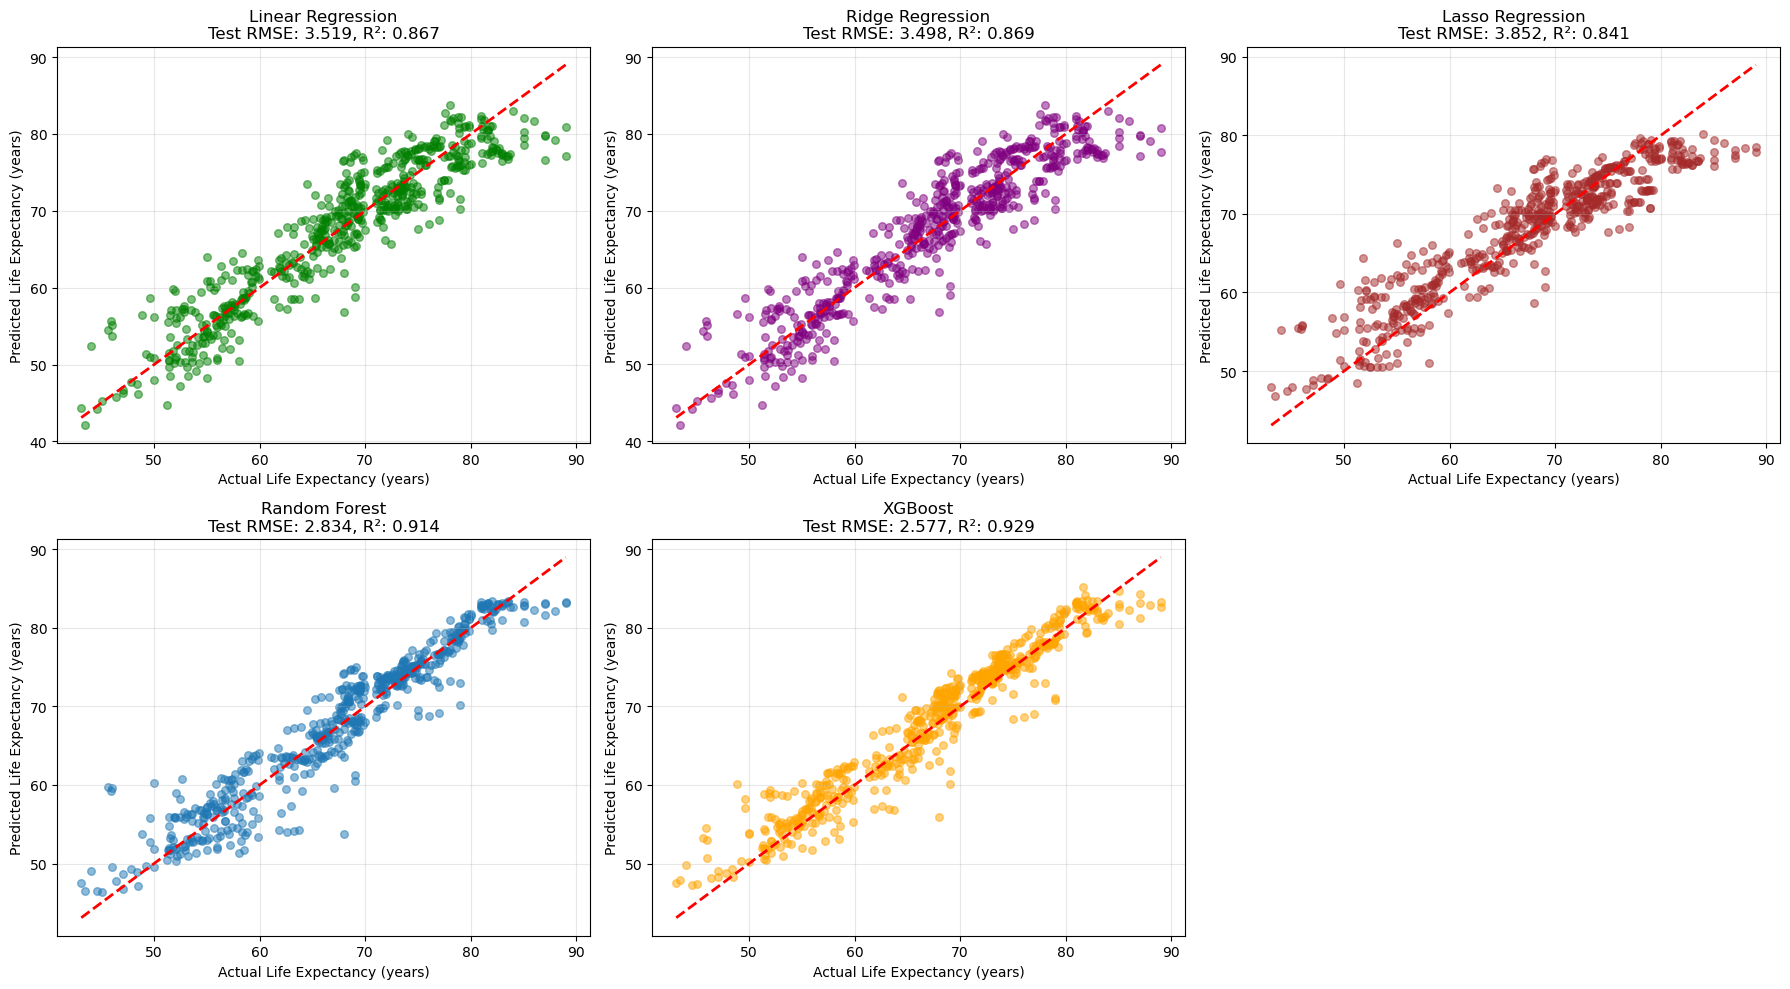

In [75]:
# model interpretation: predicted vs actual scatter plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# linear regression
axes[0, 0].scatter(y_test, y_pred_lr, alpha=0.5, s=30, color='green')
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Life Expectancy (years)')
axes[0, 0].set_ylabel('Predicted Life Expectancy (years)')
axes[0, 0].set_title(f'Linear Regression\nTest RMSE: {rmse_lr:.3f}, R²: {r2_lr:.3f}')
axes[0, 0].grid(True, alpha=0.3)

# ridge regression
axes[0, 1].scatter(y_test, y_pred_ridge, alpha=0.5, s=30, color='purple')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Life Expectancy (years)')
axes[0, 1].set_ylabel('Predicted Life Expectancy (years)')
axes[0, 1].set_title(f'Ridge Regression\nTest RMSE: {rmse_ridge:.3f}, R²: {r2_ridge:.3f}')
axes[0, 1].grid(True, alpha=0.3)

# lasso regression
axes[0, 2].scatter(y_test, y_pred_lasso, alpha=0.5, s=30, color='brown')
axes[0, 2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 2].set_xlabel('Actual Life Expectancy (years)')
axes[0, 2].set_ylabel('Predicted Life Expectancy (years)')
axes[0, 2].set_title(f'Lasso Regression\nTest RMSE: {rmse_lasso:.3f}, R²: {r2_lasso:.3f}')
axes[0, 2].grid(True, alpha=0.3)

# random forest
axes[1, 0].scatter(y_test, y_pred_rf, alpha=0.5, s=30)
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual Life Expectancy (years)')
axes[1, 0].set_ylabel('Predicted Life Expectancy (years)')
axes[1, 0].set_title(f'Random Forest\nTest RMSE: {rmse_rf:.3f}, R²: {r2_rf:.3f}')
axes[1, 0].grid(True, alpha=0.3)

# xgboost
axes[1, 1].scatter(y_test, y_pred_xgb, alpha=0.5, s=30, color='orange')
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Life Expectancy (years)')
axes[1, 1].set_ylabel('Predicted Life Expectancy (years)')
axes[1, 1].set_title(f'XGBoost\nTest RMSE: {rmse_xgb:.3f}, R²: {r2_xgb:.3f}')
axes[1, 1].grid(True, alpha=0.3)

# hide the last subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

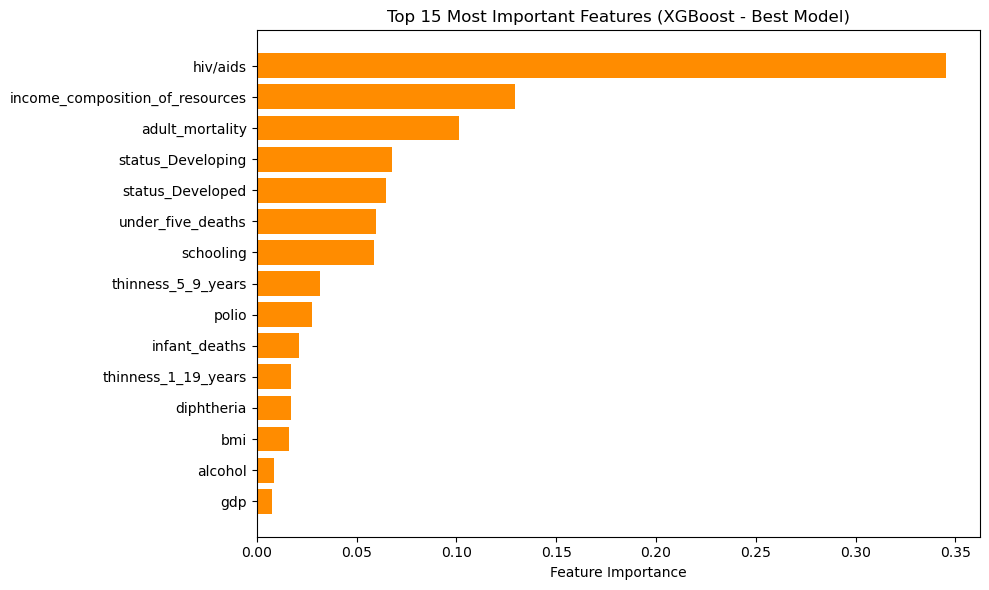


Top 10 Most Important Features:


,feature,importance
11,hiv/aids,0.345091
16,income_composition_of_resources,0.129250
0,adult_mortality,0.101524
19,status_Developing,0.067541
18,status_Developed,0.064784
7,under_five_deaths,0.059646
17,schooling,0.058757
15,thinness_5_9_years,0.031807
8,polio,0.027625
1,infant_deaths,0.021404


In [78]:
# xgboost feature importance
preprocessor_fitted = xgb_best.named_steps['preprocessing']
feature_names = preprocessor_fitted.get_feature_names_out()

xgb_model = xgb_best.named_steps['model']
xgb_importances = xgb_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_importances
}).sort_values('importance', ascending=False)

# clean name format
importance_df['feature'] = importance_df['feature'].str.replace('num__', '').str.replace('cat__', '')

# plot top 15 features
plt.figure(figsize=(10, 6))
top_n = 15
plt.barh(range(top_n), importance_df['importance'].head(top_n), color='darkorange')
plt.yticks(range(top_n), importance_df['feature'].head(top_n))
plt.xlabel('Feature Importance')
plt.title(f'Top {top_n} Most Important Features (XGBoost - Best Model)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
display(importance_df.head(10))